In [1]:
# Instalando bibliotecas
!pip install pandas numpy matplotlib seaborn yfinance mplfinance statsmodels
!pip install --upgrade ta

In [2]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.api import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
def teste_estacionariedade(x):
  # Aplicar o teste de Dickey-Fuller
  resultado_adf = adfuller(x)

  # Extrair os resultados do teste
  adf_statistica, p_valor, lags, nobs, valores_criticos, icbest = resultado_adf

  # Exibir os resultados
  print("Estatística ADF:", adf_statistica)
  print("Valor de p:", p_valor)
  print("Valores Críticos:", valores_criticos)

  # Interpretar os resultados
  if p_valor <= 0.05:
      print("A série é estacionária (p-valor <= 0.05)")
  else:
      print("A série não é estacionária (p-valor > 0.05)")

In [4]:
# Plotando o gráfico de candlestick
def plotar_dados(x):
  df = x.copy()
  kwargs = {'warn_too_much_data': len(df)}

  plt.figure(figsize=(18,6))
  mpf.plot(df, type='candle', title='Gráfico de Candlestick', ylabel='Preço', volume=True, **kwargs)
  plt.show()

# Gerando dados aleatórios

In [5]:
np.random.seed(42)

In [6]:
# Número de pontos de dados na série
n_points = 100

# Criar um array de tempo
t = np.arange(n_points)

# Criar uma série temporal não estacionária com uma tendência linear
tendencia_linear = 0.05 * t  # Uma tendência crescente ao longo do tempo
ruido = np.random.normal(0, 1, n_points)  # Adicionando ruído aleatório

serie_temporal_nao_estacionaria = tendencia_linear + ruido

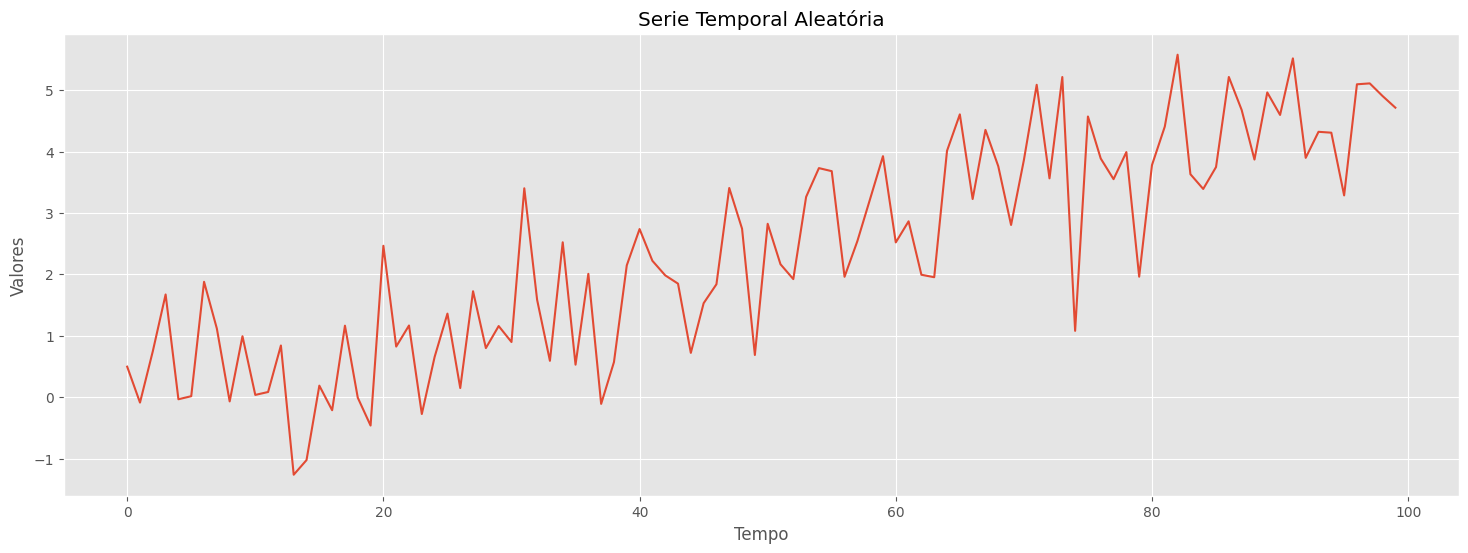

In [7]:
plt.figure(figsize=(18,6))
plt.plot(serie_temporal_nao_estacionaria)
plt.xlabel("Tempo")
plt.ylabel("Valores")
plt.title("Serie Temporal Aleatória")
plt.show()

In [8]:
teste_estacionariedade(serie_temporal_nao_estacionaria)

Estatística ADF: -0.6116640386850246
Valor de p: 0.8683245904473954
Valores Críticos: {'1%': -3.5011373281819504, '5%': -2.8924800524857854, '10%': -2.5832749307479226}
A série não é estacionária (p-valor > 0.05)


## Estacionariezando

In [9]:
# Diferenciação de primeira ordem para remover a tendência linear
diferenciada = np.diff(serie_temporal_nao_estacionaria, n=1)

In [10]:
# Suavização por média móvel para reduzir flutuações
janela = 5  # Tamanho da janela de média móvel
media_movel = pd.Series(serie_temporal_nao_estacionaria).rolling(window=janela, center=True).mean()
suavizada = np.nan_to_num(serie_temporal_nao_estacionaria - media_movel)

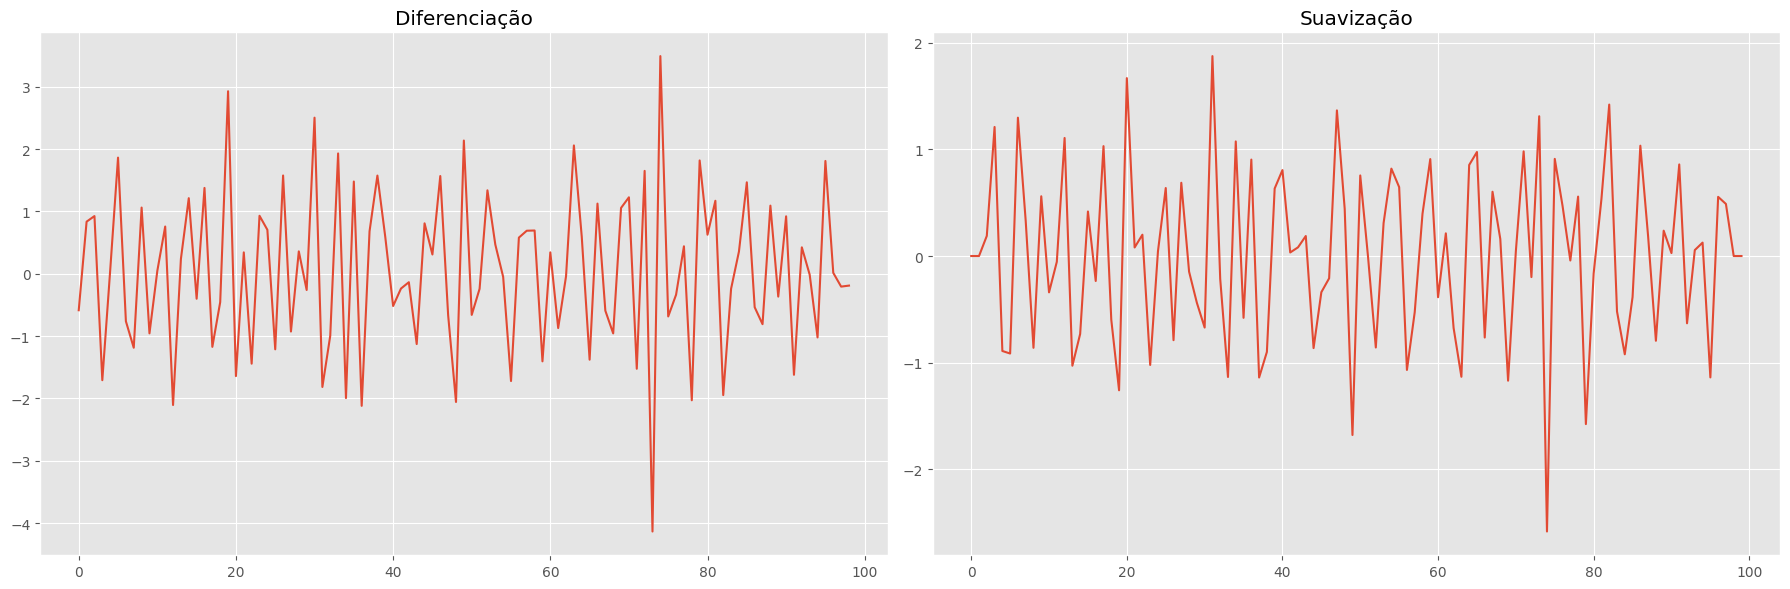

In [11]:
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.plot(diferenciada)
plt.title('Diferenciação')

plt.subplot(1, 2, 2)
plt.plot(suavizada)
plt.title('Suavização')

plt.tight_layout()
plt.show()

In [12]:
teste_estacionariedade(diferenciada)

Estatística ADF: -5.194567863079884
Valor de p: 9.019393985741834e-06
Valores Críticos: {'1%': -3.506057133647011, '5%': -2.8946066061911946, '10%': -2.5844100201994697}
A série é estacionária (p-valor <= 0.05)


In [13]:
teste_estacionariedade(suavizada)

Estatística ADF: -6.307272036021721
Valor de p: 3.2999641292448236e-08
Valores Críticos: {'1%': -3.5078527246648834, '5%': -2.895382030636155, '10%': -2.584823877658872}
A série é estacionária (p-valor <= 0.05)


## Autocorrelação

<Figure size 1800x600 with 0 Axes>

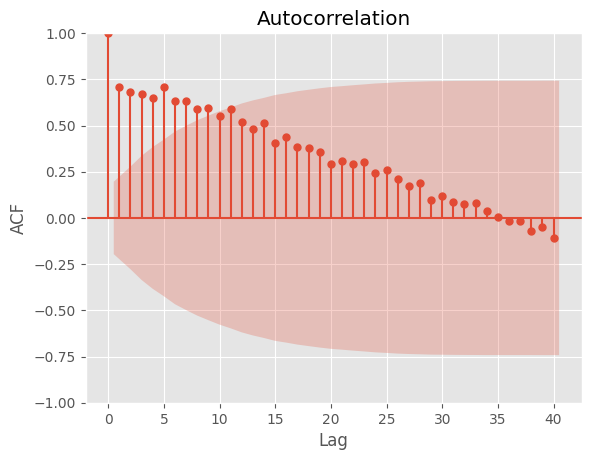

In [14]:
plt.figure(figsize=(18,6))
plot_acf(serie_temporal_nao_estacionaria, lags=40)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

## Decompondo

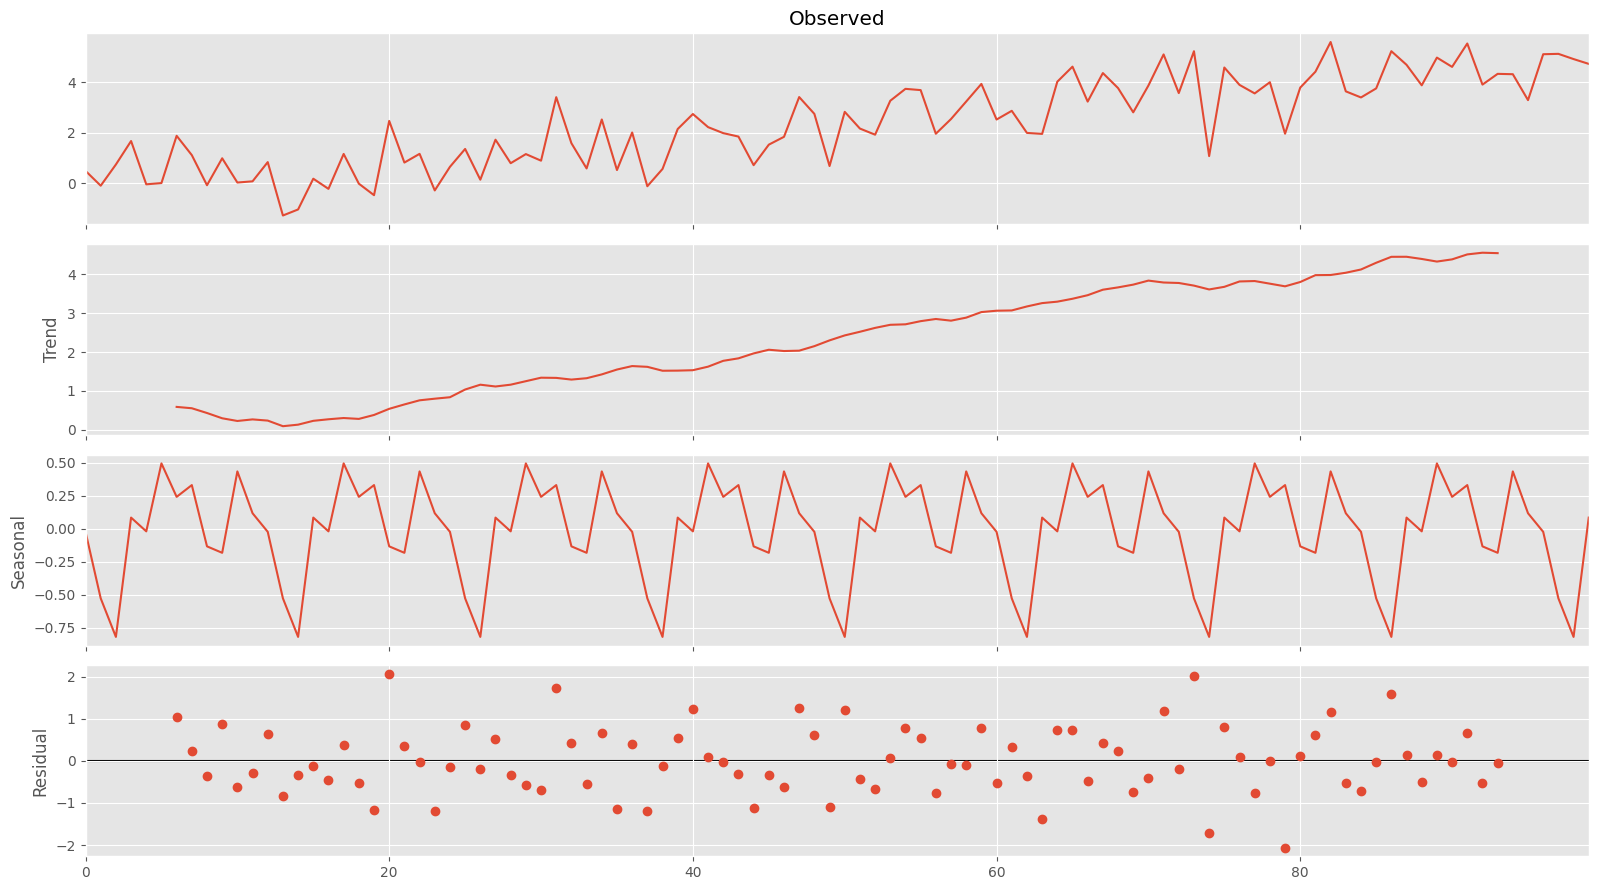

In [15]:
PERIOD = 12

decomp_viz = sm.tsa.seasonal_decompose(serie_temporal_nao_estacionaria, period=PERIOD)
fig = decomp_viz.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

## Autoregressive

In [16]:
treino = serie_temporal_nao_estacionaria[:80]
teste = serie_temporal_nao_estacionaria[80:]

### AR

In [17]:
modelo = AutoReg(treino, 5)
resultado = modelo.fit()
print(resultado.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   80
Model:                     AutoReg(5)   Log Likelihood                -106.530
Method:               Conditional MLE   S.D. of innovations              1.001
Date:                Tue, 26 Sep 2023   AIC                            227.061
Time:                        12:29:05   BIC                            243.283
Sample:                             5   HQIC                           233.538
                                   80                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2862      0.206      1.390      0.165      -0.117       0.690
y.L1           0.1479      0.110      1.346      0.178      -0.067       0.363
y.L2           0.1466      0.110      1.333      0.1

In [18]:
pred = resultado.predict(start=len(treino), end=len(treino)+len(teste)-1)

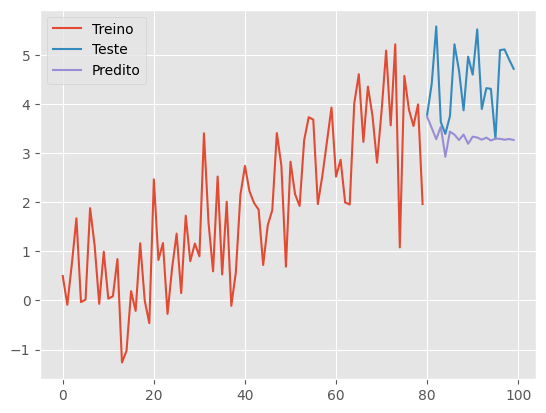

In [19]:
plt.plot(range(0,80,1), treino, label='Treino')
plt.plot(range(80,100,1), teste, label='Teste')
plt.plot(range(80,100,1), pred, label='Predito')
plt.legend()

In [20]:
best = 1e6
i_best = 0

for i in range(1,20):
  modelo = AutoReg(treino, i)
  resultado = modelo.fit()
  AIC = resultado.aic
  X_pred = resultado.predict(start=len(treino), end=len(treino)+len(teste)-1)
  MSE = mean_squared_error(teste, pred)
  RMSE = np.sqrt(MSE)
  if(RMSE<best):
      best = RMSE
      i_best = i
  print("i = {} AIC = {:0.2f} RMSE = {:0.3f}".format(i,AIC,RMSE))

print("Melhor i = {}".format(i_best))

i = 1 AIC = 260.38 RMSE = 1.332
i = 2 AIC = 247.21 RMSE = 1.332
i = 3 AIC = 239.75 RMSE = 1.332
i = 4 AIC = 237.32 RMSE = 1.332
i = 5 AIC = 227.06 RMSE = 1.332
i = 6 AIC = 225.64 RMSE = 1.332
i = 7 AIC = 222.79 RMSE = 1.332
i = 8 AIC = 222.86 RMSE = 1.332
i = 9 AIC = 220.91 RMSE = 1.332
i = 10 AIC = 220.70 RMSE = 1.332
i = 11 AIC = 215.57 RMSE = 1.332
i = 12 AIC = 214.13 RMSE = 1.332
i = 13 AIC = 214.38 RMSE = 1.332
i = 14 AIC = 206.51 RMSE = 1.332
i = 15 AIC = 197.36 RMSE = 1.332
i = 16 AIC = 197.71 RMSE = 1.332
i = 17 AIC = 196.68 RMSE = 1.332
i = 18 AIC = 196.38 RMSE = 1.332
i = 19 AIC = 195.88 RMSE = 1.332
Melhor i = 1


### ARIMA

In [21]:
modelo = ARIMA(treino, order=(2,1,2))
resultado = modelo.fit()
print(resultado.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -113.060
Date:                Tue, 26 Sep 2023   AIC                            236.120
Time:                        12:29:05   BIC                            247.967
Sample:                             0   HQIC                           240.867
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9709      0.325     -2.984      0.003      -1.609      -0.333
ar.L2         -0.1887      0.157     -1.200      0.230      -0.497       0.119
ma.L1          0.1024      0.294      0.348      0.7

In [22]:
print('Coefficients: %s' % resultado.params)

Coefficients: [-0.97086572 -0.18865741  0.1023995  -0.65665989  1.00884687]


In [23]:
pred = resultado.predict(start=len(treino), end=len(treino)+len(teste)-1)

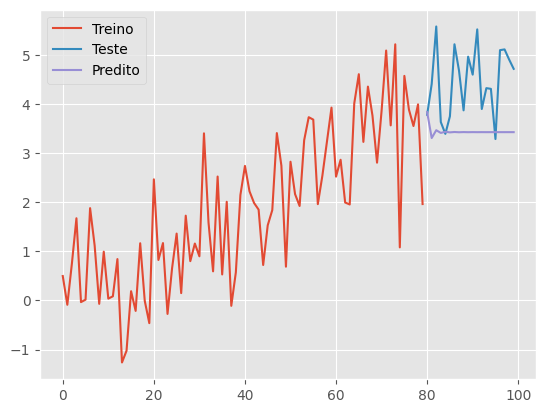

In [24]:
plt.plot(range(0,80,1), treino, label='Treino')
plt.plot(range(80,100,1), teste, label='Teste')
plt.plot(range(80,100,1), pred, label='Predito')
plt.legend()

In [25]:
best = 1e6
i_best = 0
j_best = 0
k_best = 0

for i in range(1,4):
    for j in range(0,3):
        for k in range(0,2):
            modelo = ARIMA(treino, order=(i,k,j))
            resultado = modelo.fit()
            AIC = resultado.aic
            pred = resultado.predict(start=len(treino), end=len(treino)+len(teste)-1)
            MSE = mean_squared_error(teste, pred)
            RMSE = np.sqrt(MSE)
            if(RMSE<best):
                best = RMSE
                i_best = i
                j_best = j
                k_best = k
            print("i = {} j = {}, k={},  AIC = {:0.2f} RMSE = {:0.2f}".format(i,j,k,AIC,RMSE))

print("Melhor i = {}".format(i_best))
print("Melhor k = {}".format(k_best))
print("Melhor j = {}".format(j_best))

i = 1 j = 0, k=0,  AIC = 263.86 RMSE = 2.70
i = 1 j = 0, k=1,  AIC = 253.30 RMSE = 1.92
i = 1 j = 1, k=0,  AIC = 239.88 RMSE = 1.50
i = 1 j = 1, k=1,  AIC = 234.25 RMSE = 1.25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


i = 1 j = 2, k=0,  AIC = 241.14 RMSE = 1.50
i = 1 j = 2, k=1,  AIC = 235.85 RMSE = 1.24
i = 2 j = 0, k=0,  AIC = 253.91 RMSE = 2.57
i = 2 j = 0, k=1,  AIC = 244.66 RMSE = 1.68


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


i = 2 j = 1, k=0,  AIC = 241.28 RMSE = 1.50
i = 2 j = 1, k=1,  AIC = 235.79 RMSE = 1.25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


i = 2 j = 2, k=0,  AIC = 242.93 RMSE = 1.47
i = 2 j = 2, k=1,  AIC = 236.12 RMSE = 1.23
i = 3 j = 0, k=0,  AIC = 248.69 RMSE = 2.32
i = 3 j = 0, k=1,  AIC = 244.22 RMSE = 1.55
i = 3 j = 1, k=0,  AIC = 242.78 RMSE = 1.50
i = 3 j = 1, k=1,  AIC = 237.69 RMSE = 1.25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


i = 3 j = 2, k=0,  AIC = 243.16 RMSE = 1.47
i = 3 j = 2, k=1,  AIC = 238.09 RMSE = 1.23
Melhor i = 2
Melhor k = 1
Melhor j = 2


# Dados Financeiros

In [26]:
# Símbolo da ação que você deseja baixar
symbol = 'AAPL'

# Baixe dados históricos do Yahoo Finance usando yfinance
aapl_data = yf.download(symbol, start="2013-01-01", end="2023-01-01")

display(aapl_data.head())

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.791187,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.579247,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.117435,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.022627,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.065750,458707200


# Plotando em formato de Candlestick

<Figure size 1800x600 with 0 Axes>

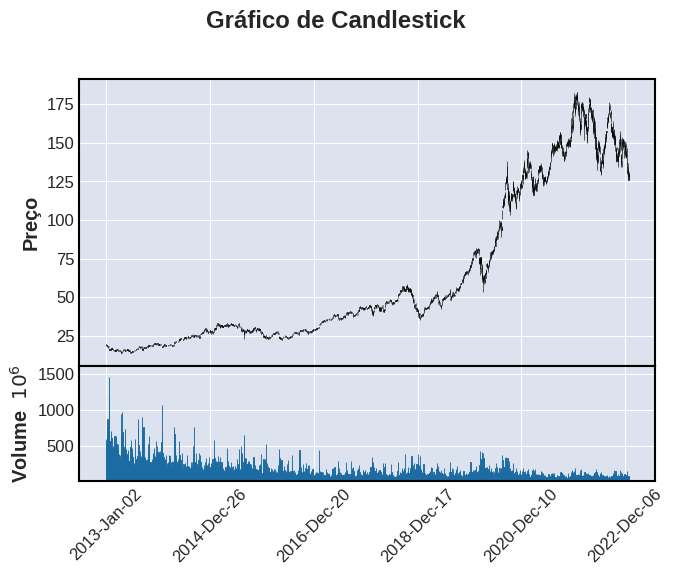

In [27]:
plotar_dados(aapl_data)

In [28]:
aapl_data["variation"] = np.log(aapl_data["Close"]/aapl_data["Open"])

In [29]:
aapl_data

,Open,High,Low,Close,Adj Close,Volume,variation
Date,,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.791187,560518000,-0.008687
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.579247,352965200,-0.010606
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.117435,594333600,-0.018742
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.022627,484156400,0.003633
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.065750,458707200,-0.007397
...,...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.299820,63814900,0.007154
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.477600,69007800,-0.010329
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.504539,85438400,-0.028393


In [30]:
teste_estacionariedade(aapl_data["variation"])

Estatística ADF: -54.92814498460784
Valor de p: 0.0
Valores Críticos: {'1%': -3.4329507078222634, '5%': -2.8626889823128554, '10%': -2.567381647203466}
A série é estacionária (p-valor <= 0.05)


## Criando e utilizando Features

In [31]:
from ta.volatility import AverageTrueRange
from ta.momentum import RSIIndicator

In [32]:
# Initialize ATR
atr = AverageTrueRange(high=aapl_data["Close"], low=aapl_data["Low"], close=aapl_data["Close"],
                                window=14)

rsi = RSIIndicator(close=aapl_data["Close"], window=4)

# Adiciona Features ao DataFrame
aapl_data['ATR'] = atr.average_true_range()
aapl_data['RSI'] = rsi.rsi()

aapl_data

,Open,High,Low,Close,Adj Close,Volume,variation,ATR,RSI
Date,,,,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.791187,560518000,-0.008687,0.000000,NaN
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.579247,352965200,-0.010606,0.000000,NaN
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.117435,594333600,-0.018742,0.000000,NaN
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.022627,484156400,0.003633,0.000000,0.000000
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.065750,458707200,-0.007397,0.000000,9.305293
...,...,...,...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.299820,63814900,0.007154,3.521692,27.641020
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.477600,69007800,-0.010329,3.494428,21.117805
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.504539,85438400,-0.028393,3.541969,12.524879


In [33]:
aapl_data.dropna(axis=0, inplace=True)
aapl_data

,Open,High,Low,Close,Adj Close,Volume,variation,ATR,RSI
Date,,,,,,,,,
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.022627,484156400,0.003633,0.000000,0.000000
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.065750,458707200,-0.007397,0.000000,9.305293
2013-01-09,18.660713,18.750357,18.428213,18.467857,15.814658,407604400,-0.010389,0.000000,5.402392
2013-01-10,18.876785,18.882856,18.411428,18.696787,16.010704,601146000,-0.009581,0.000000,34.153180
2013-01-11,18.607143,18.761429,18.536428,18.582144,15.912527,350506800,-0.001344,0.000000,28.391570
...,...,...,...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.299820,63814900,0.007154,3.521692,27.641020
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.477600,69007800,-0.010329,3.494428,21.117805
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.504539,85438400,-0.028393,3.541969,12.524879


In [34]:
X = (aapl_data[["ATR","RSI"]].shift(1)).fillna(0)
Y = aapl_data["variation"]

## Aplicando modelos de Aprendizado de Máquina

In [35]:
n = int(len(X)*0.8)
x_treino, x_teste = X[:n], X[n:]
y_treino, y_teste = Y[:n], Y[n:]

In [36]:
# Crie e ajuste o modelo de Regressão Linear
lr_model = LinearRegression()
lr_model.fit(x_treino, y_treino)

# Crie e ajuste o modelo KNN
knn_model = KNeighborsRegressor(n_neighbors=5)  # Você pode ajustar o número de vizinhos
knn_model.fit(x_treino, y_treino)

# Crie e ajuste o modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100)  # Você pode ajustar o número de estimadores
rf_model.fit(x_treino, y_treino)


RandomForestRegressor()

In [37]:
# Faça previsões usando os modelos
lr_predictions = lr_model.predict(x_teste)
knn_predictions = knn_model.predict(x_teste)
rf_predictions = rf_model.predict(x_teste)

In [38]:
# Avalie o desempenho dos modelos
lr_rmse = np.sqrt(mean_squared_error(y_teste, lr_predictions))
knn_rmse = np.sqrt(mean_squared_error(y_teste, knn_predictions))
rf_rmse = np.sqrt(mean_squared_error(y_teste, rf_predictions))

lr_r2 = r2_score(y_teste, lr_predictions)
knn_r2 = r2_score(y_teste, knn_predictions)
rf_r2 = r2_score(y_teste, rf_predictions)

# Imprima as métricas
print("Regressão Linear RMSE:", lr_rmse)
print("Regressão Linear R^2:", lr_r2)
print("KNN RMSE:", knn_rmse)
print("KNN R^2:", knn_r2)
print("Random Forest RMSE:", rf_rmse)
print("Random Forest R^2:", rf_r2)

Regressão Linear RMSE: 0.01621208080502244
Regressão Linear R^2: -0.00012795864856540717
KNN RMSE: 0.018618708119580534
KNN R^2: -0.3190982254897077
Random Forest RMSE: 0.021719518311741383
Random Forest R^2: -0.7950577600057169


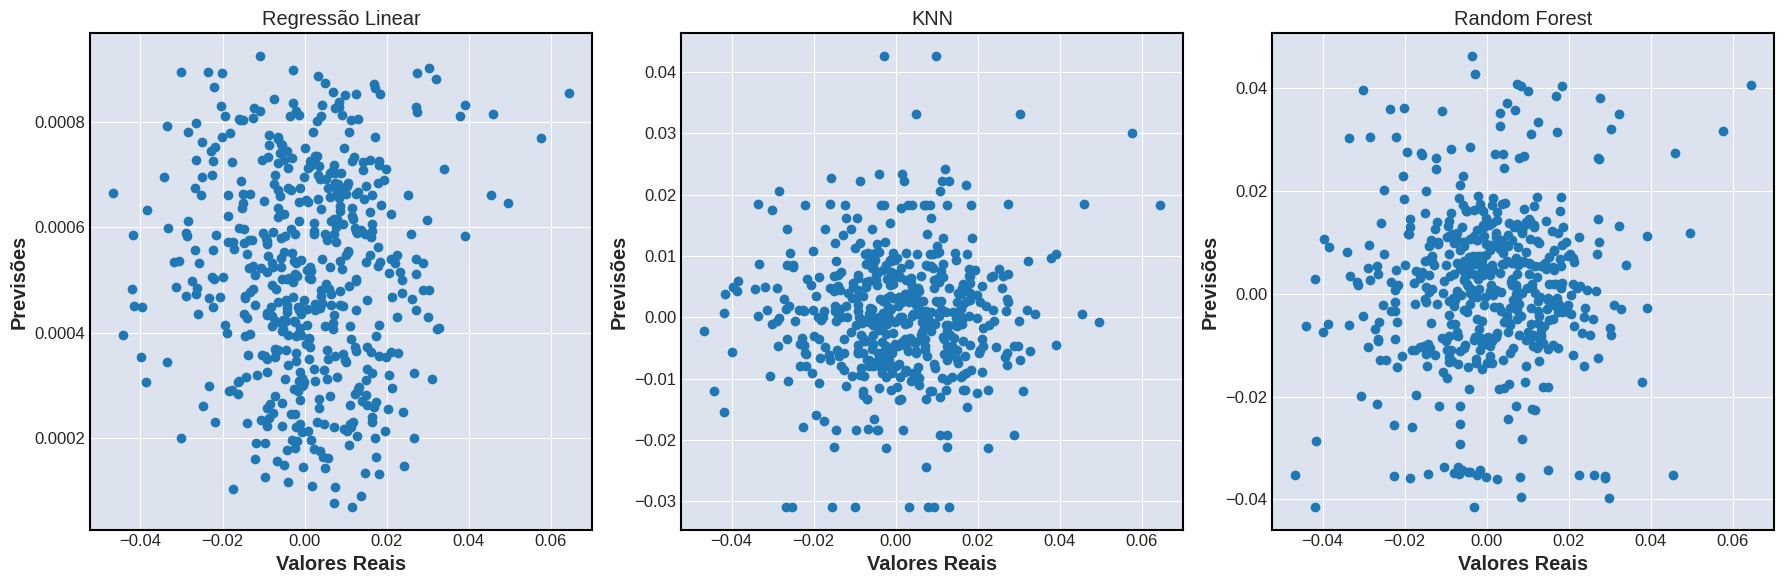

In [39]:
# Crie gráficos para comparar as previsões com os valores reais
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.scatter(y_teste, lr_predictions)
plt.title("Regressão Linear")
plt.xlabel("Valores Reais")
plt.ylabel("Previsões")

plt.subplot(132)
plt.scatter(y_teste, knn_predictions)
plt.title("KNN")
plt.xlabel("Valores Reais")
plt.ylabel("Previsões")

plt.subplot(133)
plt.scatter(y_teste, rf_predictions)
plt.title("Random Forest")
plt.xlabel("Valores Reais")
plt.ylabel("Previsões")

plt.tight_layout()
plt.show()

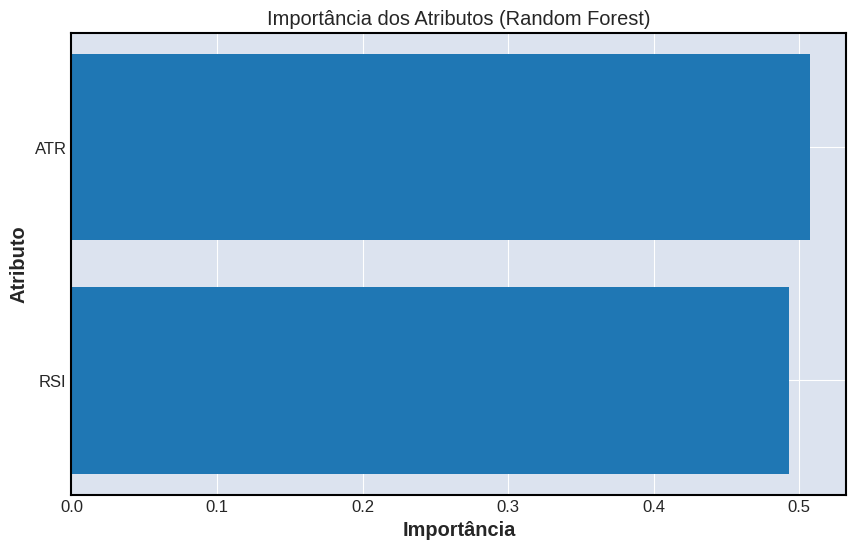

In [40]:
# Obtenha a importância das características do modelo Random Forest
feature_importance = rf_model.feature_importances_

# Obtenha os nomes das características
feature_names = X.columns

# Crie um DataFrame para armazenar a importância das características
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Ordene as características por importância em ordem decrescente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Crie um gráfico de barras para visualizar a importância das características
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importância')
plt.ylabel('Atributo')
plt.title('Importância dos Atributos (Random Forest)')
plt.gca().invert_yaxis()  # Inverter o eixo y para a característica mais importante no topo
plt.show()


In [41]:
from sklearn.tree import export_graphviz
import graphviz

# Escolha uma árvore específica da Random Forest (por exemplo, a primeira árvore)
tree_to_visualize = rf_model.estimators_[0]

# Exporte a árvore em formato DOT
dot_data = export_graphviz(tree_to_visualize, out_file=None,
                           feature_names=X.columns,
                           filled=True, rounded=True, special_characters=True)

# Crie um objeto de gráfico Graphviz
graph = graphviz.Source(dot_data)

# Salve ou exiba a árvore (pode ser necessário ajustar o caminho)
graph.render("random_forest_tree")

'random_forest_tree.pdf'

In [42]:
lr_model.intercept_, lr_model.coef_

(0.0008096821578468808, array([ 4.15280255e-05, -8.30486112e-06]))

# Baixando dados de outra empresa

In [43]:
# Baixar dados de outra empresa (por exemplo, Microsoft - 'MSFT')
symbol2 = "MSFT"
msft_data = yf.download(symbol2, start="2013-01-01", end="2023-01-01")
msft_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,27.250000,27.730000,27.150000,27.620001,22.620340,52899300
2013-01-03,27.629999,27.650000,27.160000,27.250000,22.317320,48294400
2013-01-04,27.270000,27.340000,26.730000,26.740000,21.899630,52521100
2013-01-07,26.770000,26.879999,26.639999,26.690001,21.858681,37110400
2013-01-08,26.750000,26.790001,26.459999,26.549999,21.744024,44703100
...,...,...,...,...,...,...
2022-12-23,236.110001,238.869995,233.940002,238.729996,237.112091,21207000
2022-12-27,238.699997,238.929993,235.830002,236.960007,235.354095,16688600
2022-12-28,236.889999,239.720001,234.169998,234.529999,232.940552,17457100


In [44]:
# Análise multivariada: correlação entre os preços de fechamento de duas empresas
correlation = msft_data['Close'].corr(aapl_data['Close'])
print(f"Correlação entre {symbol} e {symbol2}: {correlation:.2f}")

Correlação entre AAPL e MSFT: 0.98


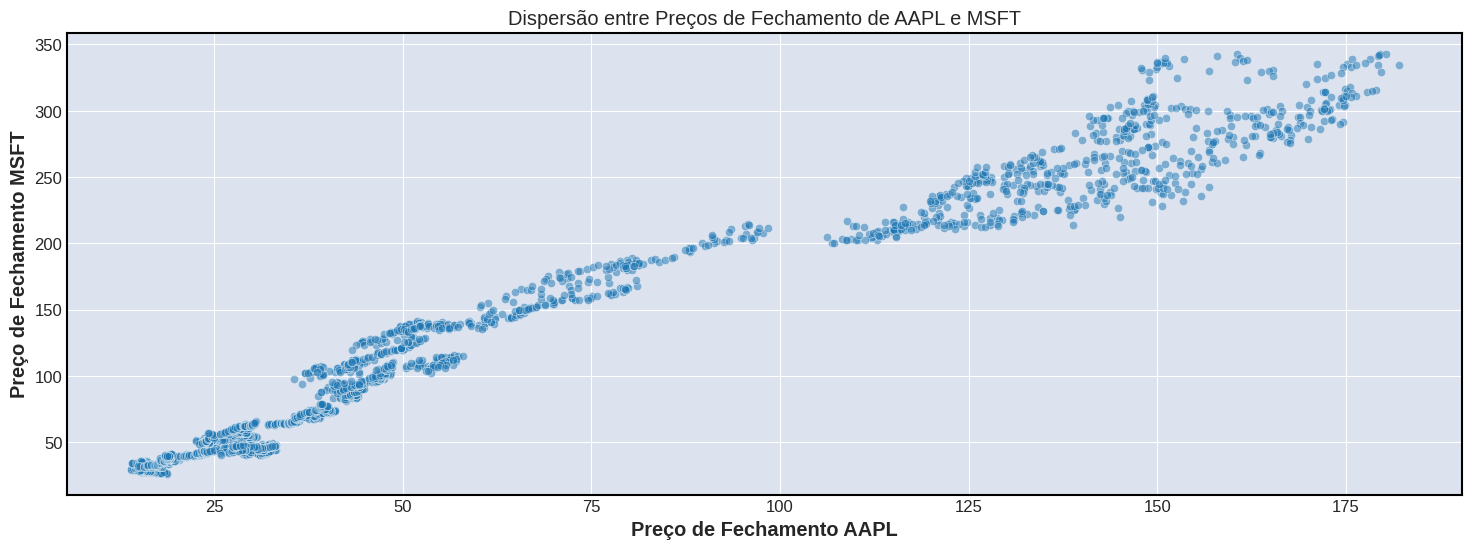

In [45]:
# Gráfico de dispersão para visualizar a correlação
plt.figure(figsize=(18, 6))
plt.title(f"Dispersão entre Preços de Fechamento de {symbol} e {symbol2}")
sns.scatterplot(x=aapl_data['Close'], y=msft_data['Close'], alpha=0.5)
plt.xlabel(f"Preço de Fechamento {symbol}")
plt.ylabel(f"Preço de Fechamento {symbol2}")
plt.grid(True)
plt.show()

In [46]:
novo_df = aapl_data.merge(msft_data, on='Date', how='inner')
novo_df

,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,variation,ATR,RSI,Open_y,High_y,Low_y,Close_y,Adj Close_y,Volume_y
Date,,,,,,,,,,,,,,,
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.022627,484156400,0.003633,0.000000,0.000000,26.770000,26.879999,26.639999,26.690001,21.858681,37110400
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.065750,458707200,-0.007397,0.000000,9.305293,26.750000,26.790001,26.459999,26.549999,21.744024,44703100
2013-01-09,18.660713,18.750357,18.428213,18.467857,15.814658,407604400,-0.010389,0.000000,5.402392,26.719999,26.750000,26.559999,26.700001,21.866875,49047900
2013-01-10,18.876785,18.882856,18.411428,18.696787,16.010704,601146000,-0.009581,0.000000,34.153180,26.650000,26.980000,26.290001,26.459999,21.670319,71431300
2013-01-11,18.607143,18.761429,18.536428,18.582144,15.912527,350506800,-0.001344,0.000000,28.391570,26.490000,26.930000,26.280001,26.830000,21.973343,55512100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.299820,63814900,0.007154,3.521692,27.641020,236.110001,238.869995,233.940002,238.729996,237.112091,21207000
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.477600,69007800,-0.010329,3.494428,21.117805,238.699997,238.929993,235.830002,236.960007,235.354095,16688600
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.504539,85438400,-0.028393,3.541969,12.524879,236.889999,239.720001,234.169998,234.529999,232.940552,17457100


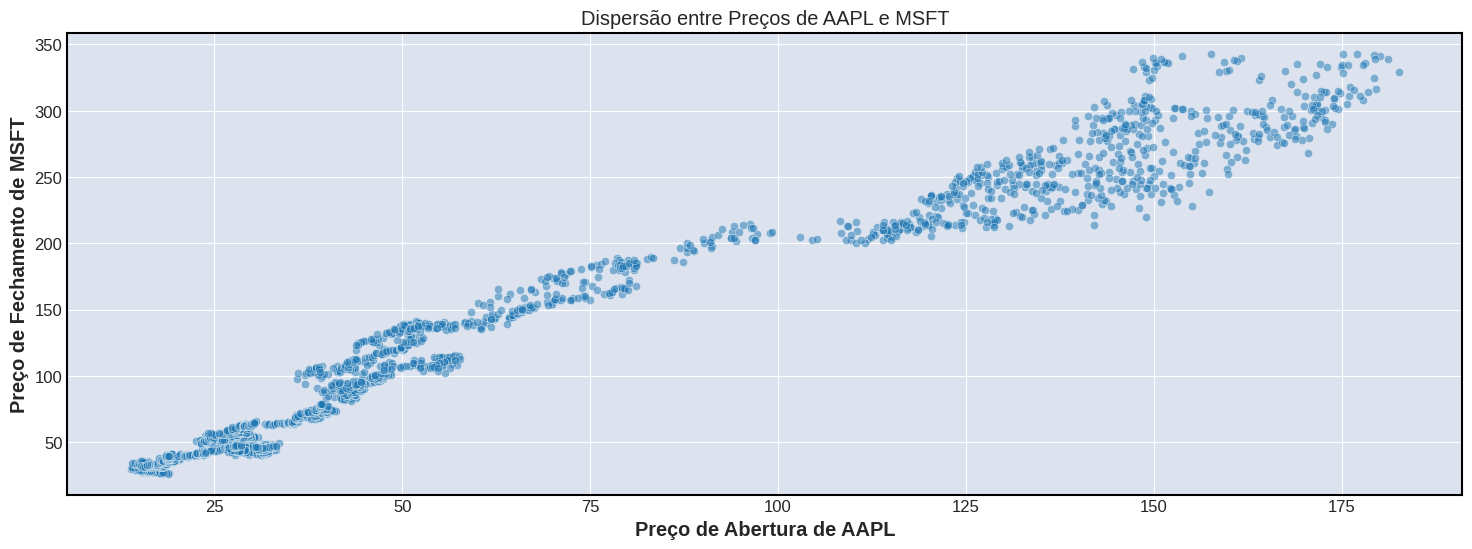

In [47]:
# Gráfico de dispersão para visualizar a correlação
plt.figure(figsize=(18, 6))
plt.title(f"Dispersão entre Preços de {symbol} e {symbol2}")
sns.scatterplot(x=novo_df['Open_x'], y=novo_df['Close_y'], alpha=0.5)
plt.xlabel(f"Preço de Abertura de {symbol}")
plt.ylabel(f"Preço de Fechamento de {symbol2}")
plt.grid(True)
plt.show()

### $ Correlação \; ? $